In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Scrape OHLC data from Yahoo Finance API for 
# S&P500 Index, CBE VIX Index, SSE Composite Index, CNY/USD rates
# throughout the time period of 2008-01-01 to 2020-04-30.

# import yfinance as yf

# raw = yf.download(
#         tickers = "^GSPC ^VIX 000001.SS CNYUSD=X",
#         start = "2007-01-01",
#         end = "2020-05-01",
#         interval = "1d",
#         group_by = "ticker"
#         )
# raw.to_csv("raw.csv", header=True)

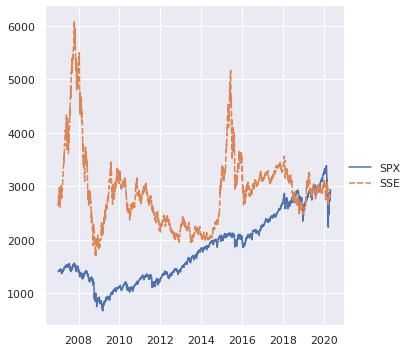

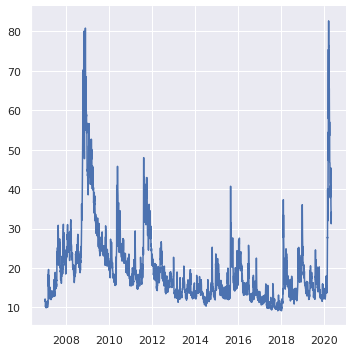

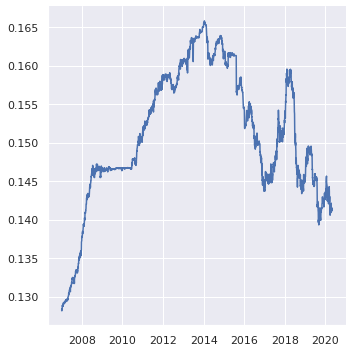

In [3]:
df = pd.read_csv("raw.csv")

# Data Cleanup and Preprocessing
# Leave only dates and close values.
df = df.iloc[3:, [0] + [6*i + 4 for i in range(4)]]
date = pd.to_datetime(df.iloc[:,0]).rename("date", inplace=True)
# initialize new dataframe
df = pd.DataFrame({"date": date,
                    "SPX": df["^GSPC.3"],
                    "VIX": df["^VIX.3"],
                    "SSE": df["000001.SS.3"],
                    "CNY": df["CNYUSD=X.3"]})
df.set_index(df["date"], drop=True, inplace=True)
df = df.dropna(axis=0, how="any")

# Manual correction of error entry 
# for this particular date in Yahoo Finance data.
# Replaced with data from investing.com
df.loc["2011-07-18", "CNY"] = 0.1546

# preserve date range Series for log-return dataframe.
date = df["date"]
del df["date"]

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# generate graphs
sns.relplot(kind="line", data=df[["SPX","SSE"]])
sns.relplot(kind="line", data=df["VIX"])
sns.relplot(kind="line", data=df["CNY"])

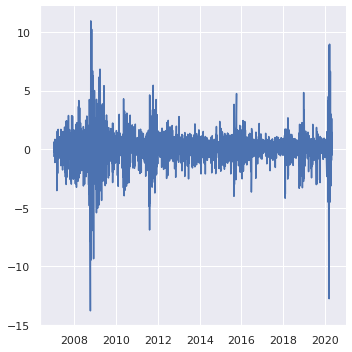

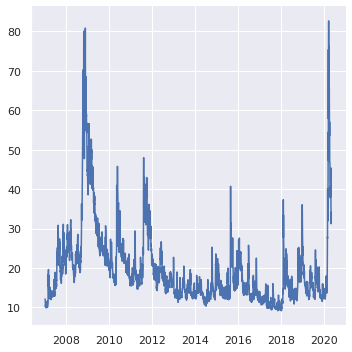

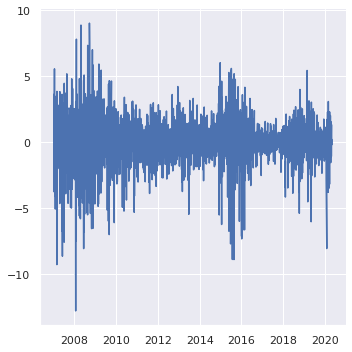

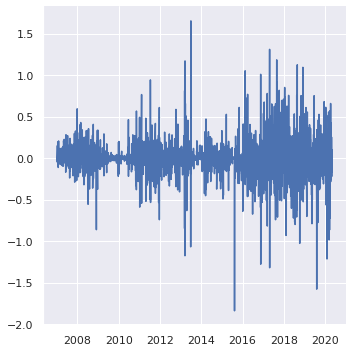

In [4]:
# Convert daily close quotes to one-day-ahead log returns in percentages + generate graphs
def getLogReturns(quotes):
    return [100 * np.log(quotes[i] / quotes[i-1])
           for i in range(1, len(quotes))]

df_lret = pd.DataFrame(columns=df.columns, index=date[1:])
for col in df_lret.columns:
    if col == "VIX":
        df_lret[col] = df[col][1:]
    else:
        df_lret[col] = getLogReturns(df[col].tolist())
    sns.relplot(kind="line", data=df_lret[col])

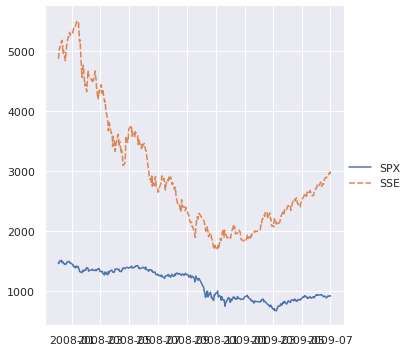

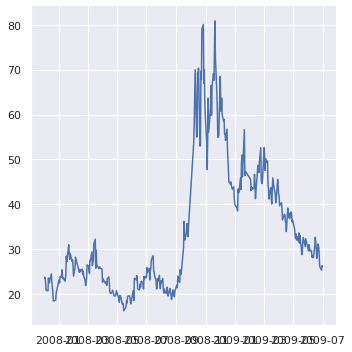

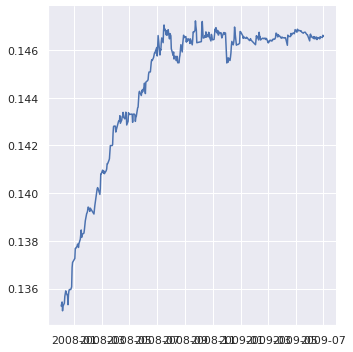

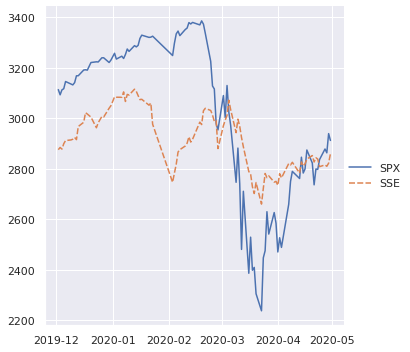

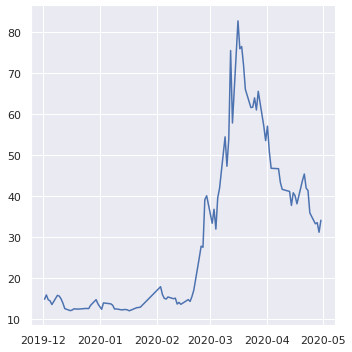

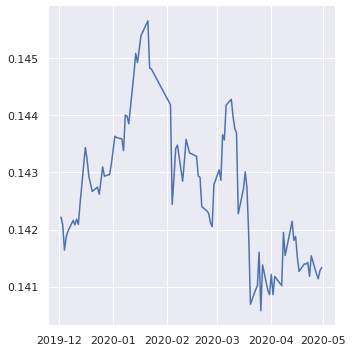

In [5]:
# Separate Dataframes for the Great Recession and Coronavirus Recession
# defined respectively as Dec 2007 ~ Jun 2009 and Dec 2019 ~

# Global Date Variables
ALL_START = "2007-01-01"
ALL_END = "2020-05-01"
TRAIN_END = "2018-12-31"
FORECAST_START = "2019-01-01"
GR_START = "2007-12-01"
GR_END = "2009-07-01"
COVID_START = "2019-12-01"
COVID_END = "2020-05-01"

COLS_EXCL_VIX = ("SPX", "SSE", "CNY")

GRdf = df[GR_START:GR_END].copy()
GRdf_lret = df_lret[GR_START:GR_END].copy()

CRdf = df[COVID_START:].copy()
CRdf_lret = df_lret[COVID_START:].copy()

resultsdb = {"ALL": ["Full Timeframe", df_lret],
             "CR": ["COVID-19 Recession", CRdf_lret]}

for data in GRdf, CRdf:
    sns.relplot(kind="line", data=data[["SPX","SSE"]])
    sns.relplot(kind="line", data=data["VIX"])
    sns.relplot(kind="line", data=data["CNY"])

In [6]:
# Diagnostic Tests

# Augmented Dickey-Fuller: Stationarity (Unit Root)
def adf(timeseries, title, cutoff=0.01):
    result = False
    
    print('Results of Dickey-Fuller Test for: ' + title)
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.6f. The series is likely stationary.' % pvalue)
        result = True
    else:
        print('p-value = %.6f. The series is likely non-stationary.' % pvalue)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print()
    
    return result

for v in resultsdb.values():
    data = v[1]
    print(v[0] + ": \n")
    for col in data.columns:
        title = " - ".join((v[0], col))
        adf(data[col], title)
        print()

Full Timeframe: 

Results of Dickey-Fuller Test for: Full Timeframe - SPX
p-value = 0.000000. The series is likely stationary.
Test Statistic                -1.003840e+01
p-value                        1.519034e-17
#Lags Used                     2.900000e+01
Number of Observations Used    3.097000e+03
Critical Value (1%)           -3.432463e+00
Critical Value (5%)           -2.862474e+00
Critical Value (10%)          -2.567267e+00
dtype: float64


Results of Dickey-Fuller Test for: Full Timeframe - VIX
p-value = 0.000136. The series is likely stationary.
Test Statistic                   -4.588621
p-value                           0.000136
#Lags Used                       12.000000
Number of Observations Used    3114.000000
Critical Value (1%)              -3.432452
Critical Value (5%)              -2.862469
Critical Value (10%)             -2.567264
dtype: float64


Results of Dickey-Fuller Test for: Full Timeframe - SSE
p-value = 0.000000. The series is likely stationary.
Test Statist

In [7]:
# Apply second-order differencing to non-stationary dataset
def getSecondOrderLogReturns(quotes):
    return [100 * np.log((quotes[i] / quotes[i-1]) / (quotes[i-1] / quotes[i-2]))
           for i in range(2, len(quotes))]

#df.loc["2019-11-25":"2019-12-01"].head()
COVID_df = resultsdb["CR"][1]
COVID_df["SPX"] = getSecondOrderLogReturns(df.loc["2019-11-27":,"SPX"].tolist())
adf(COVID_df["SPX"], "COVID-SPX")

Results of Dickey-Fuller Test for: COVID-SPX
p-value = 0.000000. The series is likely stationary.
Test Statistic                -6.011769e+00
p-value                        1.567317e-07
#Lags Used                     7.000000e+00
Number of Observations Used    8.800000e+01
Critical Value (1%)           -3.506944e+00
Critical Value (5%)           -2.894990e+00
Critical Value (10%)          -2.584615e+00
dtype: float64



True

In [25]:
# Find ARIMA(p,1,q) models for log-return series that minimize AIC
# where p,q <= 5 and excluding ARIMA(0,1,0)
import statsmodels.tsa.arima_model as arima_old
import statsmodels.tsa.arima.model as arima
import statsmodels.tsa.statespace.kalman_filter as kalman

def fit_ARIMA(timeseries, order=(5,0,5), verbose=False):
    max_p, d, max_q = order
    min_aic = 2 ** 32
    results = []
    if verbose:
        print("Approximating model fitting to save time...")
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p > 0 or q > 0:
                try:
                    model = arima_old.ARIMA(timeseries, (p,d,q))
                    fitted = model.fit(transparams=False,
                                       method="css",
                                       trend="nc",
                                       maxiter=50)
                    aic = arima_old.ARIMAResults(model, fitted.params).aic
                    if verbose:
                        print("ARIMA(" + ",".join((str(p),str(d),str(q))) + ") - AIC: " + str(aic))                    
                    results.append([aic, (p,d,q)])
                except ValueError:
                    continue

    results = sorted(results, key=lambda x: x[0])
    if verbose:
        print("Refitting best model without approximation...")
    for result in results:
        try:
            p,d,q = result[1]
            model = arima.ARIMA(timeseries, order=(p,d,q))
            res = model.fit()
            
            kal_model = kalman.KalmanFilter(timeseries, timeseries.size)
            kal_res = kal_model.filter()
#             kal = kalman.FilterResults(kal_model)
            kal = arima.ARIMA.filter(kal_res.params)
            
            arima_results = arima.ARIMAResults(model, res.params, kal)
            return arima_results.summary()
#             residuals = arima_results.resid
#             aic = arima_results.aic
#             print("ARIMA(" + ",".join((str(p),str(d),str(q))) + ") - AIC: " + str(aic))
#             if verbose:
#                 print(arima_results.summary())
#             return ((p,d,q), model, res, residuals, kal)
        except ValueError:
            continue

In [26]:
arima_verbose = False
for v in resultsdb.values():
    data = v[1]
    if len(v) == 2:
        v.append({})
    for col in COLS_EXCL_VIX:
        title = v[0] + " - " + col
        print(title)
        if v[0] == "COVID-19 Recession" and col == "SPX":
            v[2][col] = fit_ARIMA(data[col], (2,1,2), verbose=arima_verbose)
        else: 
            v[2][col] = fit_ARIMA(data[col], (2,0,2), verbose=arima_verbose)
        print(v[2][col])
#         p,d,q = v[2][col][0]
#         if arima_verbose:
#             print(title)
#             print("Best Model: ARIMA(" + ",".join((str(p),str(d),str(q))) + ")\n")
        
#         summary = arima.ARIMAResults(ARIMA[col][1], ARIMA[col][2].params).summary()
#         print(summary)

Full Timeframe - SPX
None
Full Timeframe - SSE


KeyboardInterrupt: 

In [ ]:
for v in resultsdb.values():
    for col in COLS_EXCL_VIX:
        title = v[0] + " - " + col
        print(title)
        (p,d,q), model, res, residuals, kal = v[2][col]
        arima_results = arima.ARIMAResults(model, res.params, kal)
        arima_results.test_normality
        

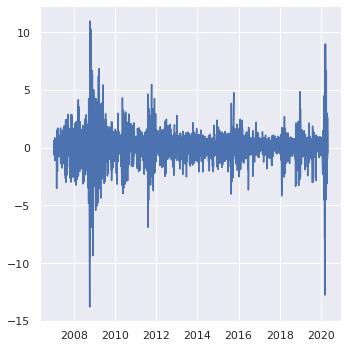

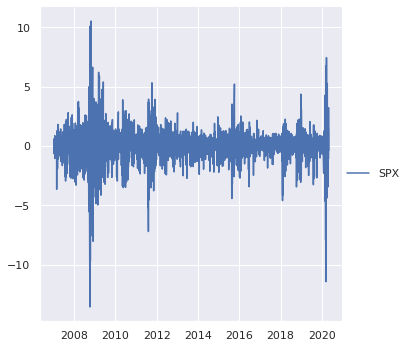

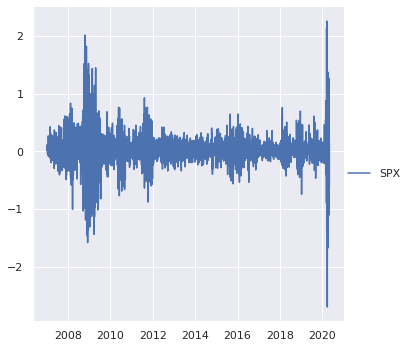

In [143]:
# Quickly populate resultsdb with known values from above cell

# def fit_arima(timeseries, pdq_tuple):
#     model = arima.ARIMA(timeseries, pdq_tuple)
#     fitted = model.fit(transparams=False)
#     residuals = arima.ARIMAResults(model, fitted.params).resid
#     return (pdq_tuple, model, fitted, residuals)

# pdq = [[(1,1,4),(1,1,5),(1,1,1),
#         (4,2,1),(5,1,1),(2,1,3)]]

# for i, v in enumerate(resultsdb.values()):
#     data = v[1]
#     if (len(v) == 2):
#         v.append({})
#     ARIMA = v[2]
#     for j, col in enumerate(COLS_EXCL_VIX):
#         if v[2] == {}:
#             ARIMA[col] = fit_arima(data[col], pdq[i][j])
#         summary = arima.ARIMAResults(ARIMA[col][1], ARIMA[col][2].params).summary()
#         print("\n" + v[0] + " - " + col + ":")
#         print(summary)

arima_res_spx = pd.DataFrame({"SPX": resultsdb["ALL"][2]["SPX"][3]},
                            index=resultsdb["ALL"][1].index)
arima_fitval_spx = pd.DataFrame({"SPX": resultsdb["ALL"][2]["SPX"][4]},
                               index=resultsdb["ALL"][1].index)
sns.relplot(kind="line", data=df_lret["SPX"])
sns.relplot(kind="line", data=arima_res_spx)
sns.relplot(kind="line", data=arima_fitval_spx)


Full Timeframe - SPX
JB statistic, p-value, Skewness, Kurtosis
25033.867942343444, 0.0, -0.9018581000369447, 16.74349831369183
SPX is within the threshold for normal distribution.

Figure(432x288)
Full Timeframe - SSE
JB statistic, p-value, Skewness, Kurtosis
3450.372896140086, 0.0, -0.625921356076147, 7.991473253511482
SSE is within the threshold for normal distribution.

Figure(432x288)
Full Timeframe - CNY
JB statistic, p-value, Skewness, Kurtosis
14746.49610160699, 0.0, -0.33684424292698695, 13.617287707579884
CNY is within the threshold for normal distribution.

Figure(432x288)
COVID-19 Recession - SPX
JB statistic, p-value, Skewness, Kurtosis
27.128709813412982, 1.2855101600330754e-06, 0.3901658145737026, 5.498930039740938
SPX is within the threshold for normal distribution.

Figure(432x288)
COVID-19 Recession - SSE
JB statistic, p-value, Skewness, Kurtosis
221.23427308945588, 9.111460456506758e-49, -1.5670842193897707, 9.744298070942756
SSE is within the threshold for normal dis

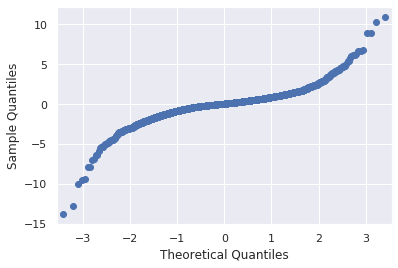

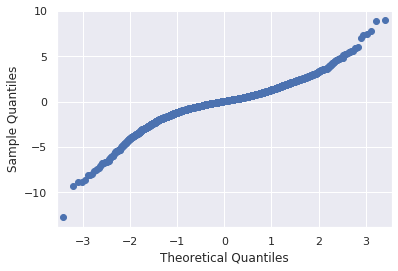

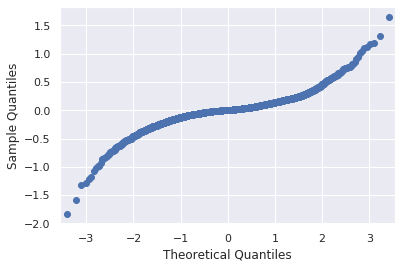

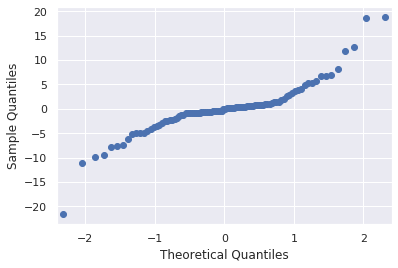

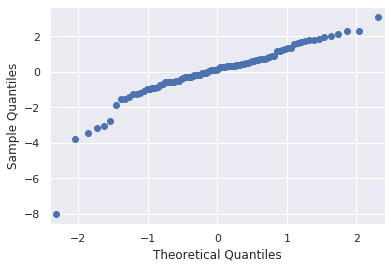

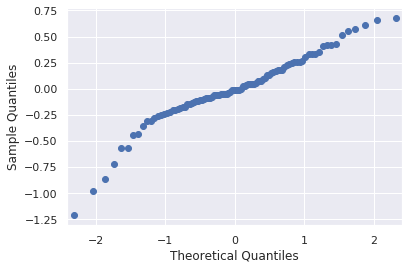

In [144]:
# Jarque-Bera Test of Normality in the ARIMA-fitted residuals + QQ plots
from statsmodels.graphics.gofplots import qqplot

for v in resultsdb.values():
    data = v[1]
    for col in COLS_EXCL_VIX:
        title = v[0] + " - " + col
        res = v[2][col][3]
        result = sm.stats.stattools.jarque_bera(res)
        print(title)
        print(", ".join(("JB statistic", "p-value", "Skewness", "Kurtosis")))
        print(", ".join(str(e) for e in result))
        if result[1] < 0.01:
            print(col + " is within the threshold for normal distribution.")
        else:
            print(col + " is non-normal.")
        print()
        print(qqplot(data[col]))

In [145]:
# Box-Ljung Test of Autocorrelation in the ARIMA residuals + ACF, PACF plots.
def ljungbox(res, lags=20, alpha=0.95, num_params=0):
    T = res.size
    rk_sq = np.square(sm.tsa.acf(res, nlags=lags))
    Qstar = T*(T+2)*np.sum(1/(T-k) * rk_sq[k] for k in range(lags))
    chisq, pval = scs.chisquare(res, alpha, ddof=num_params)
    degfree = T - num_params - 1
    return lags, Qstar, chisq, pval, degfree
    
for v in resultsdb.values():
    data = v[1]
    for col in COLS_EXCL_VIX:
        title = v[0] + " - " + col
        p,d,q = v[2][col][0]
        model = v[2][col][1]
        fitted = v[2][col][2]
        res = v[2][col][3]

        result = ljungbox(res, lags=90, alpha=0.95, num_params=p+q)
        if result[3] < 0.01:
            print(title + ": ARIMA-fitted residuals exhibit autocorrelation.")
        else:
            print(title + ": No autocorrelation.")
        print("Lags, Qstar, Chisquare, p-value, Degree of Freedom")
        print(", ".join(str(e) for e in result))
        print()

#         sm.graphics.tsa.plot_acf(data[col], lags=40, title=title + ": Autocorrelation")
#         sm.graphics.tsa.plot_pacf(data[col], lags=40, title=title + ": Partial Autocorrelation")


Full Timeframe - SPX: ARIMA-fitted residuals exhibit autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedom
90, 3279.148450953904, 8865.157180262046, 0.0, 3110

Full Timeframe - SSE: ARIMA-fitted residuals exhibit autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedom
90, 3229.0022840631095, 12463.235224356216, 0.0, 3110

Full Timeframe - CNY: No autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedom
90, 3249.546030219083, 3097.5631005111145, 0.6136894526472225, 3121

COVID-19 Recession - SPX: ARIMA-fitted residuals exhibit autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedom
90, 164.2271799173051, 966.0926255038767, 2.3010562829172895e-148, 87

COVID-19 Recession - SSE: ARIMA-fitted residuals exhibit autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedom
90, 141.38584986018915, 257.51672519658615, 2.9165535011330294e-20, 81

COVID-19 Recession - CNY: No autocorrelation.
Lags, Qstar, Chisquare, p-value, Degree of Freedo

In [161]:
# Goldfeld-Quandt Test for Heteroskedasticity in Standardized Residuals.
import statsmodels.tsa.arima.model as arima_model

for v in resultsdb.values():
    for col in COLS_EXCL_VIX:
        het_bool = False
        arima_pkg = v[2][col]
        model, fitted, res = arima_pkg[1:4]
        test_stat, p_val = arima_model.ARIMAResults(model, fitted.params).test_heteroskedasticity('breakvar')
        if p_val < 0.01:
            het_bool = True
            
        title = v[0] + " - " + col
        if het_bool:
            print(title + ": ARIMA-fitted residuals exhibit heteroskedasticity.")
        else:
            print(title + ": No heteroskedasticity.")
        print("Goldfeld-Quandt Statistic, p-value")
        print(", ".join((test_stat, p_val)))
        print()


TypeError: __init__() missing 1 required positional argument: 'filter_results'

In [146]:
# Fit a GARCH(1,1) model for each asset using the ARIMA-fitted residuals.
# Forecast the assets' 95%, 99% Value at Risk for various timeranges.
from arch import arch_model

def buildGARCH(arima_pkg, asset, dataframe, date_cutoff=ALL_END, dist='normal', verbose=True):
    arima_res = pd.DataFrame({asset: arima_pkg[3]},
                                index=dataframe.index)
    am = arch_model(arima_res, mean='Zero', vol='Garch', p=1, o=0, q=1, dist=dist)
    res = am.fit(disp='off', last_obs=date_cutoff)
    if verbose:
        print(res.summary())
        fig = res.plot(annualize='D')
    return am, res

def VaR_parametric(asset, scope="ALL", 
                   train_end_date=ALL_END, forecast_start_date=ALL_START, 
                   start_date=ALL_START, end_date=ALL_END,
                   dist='skewt', verbose=True):
    arima_pkg = resultsdb[scope][2][asset]
    data = resultsdb[scope][1][asset].copy()
    len_diff = data.size - arima_pkg[3].size
    data = data[len_diff:]
    am, res = buildGARCH(arima_pkg, asset, data, date_cutoff=train_end_date, dist=dist, verbose=verbose)
    
    forecasts = res.forecast(start=forecast_start_date)
    cond_mean = forecasts.mean[forecast_start_date:]
    cond_var = forecasts.variance[forecast_start_date:]
    q = am.distribution.ppf([0.01,0.05], res.params[-2:])
    print(q)

    VaR = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
    VaR = pd.DataFrame(VaR, columns=["1%","5%"], index=cond_var.index)
    VaR = VaR[start_date:end_date]
    
    if len(resultsdb[scope]) == 3:
        resultsdb[scope].append({})

    ax = VaR.plot(legend=True)
    ax.plot(data, color="#BBBBBB")
    ax.set_title(col + ': Parametric VaR')
    print(ax)
    
    return VaR

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                               SPX   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4221.28
Distribution:      Standardized Skew Student's t   AIC:                           8452.55
Method:                       Maximum Likelihood   BIC:                           8482.79
                                                   No. Observations:                 3127
Date:                           Sat, May 23 2020   Df Residuals:                     3122
Time:                                   16:06:57   Df Model:                            5
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

/home/majorlift/bin/miniconda3/envs/thicconda/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


AxesSubplot(0.125,0.2;0.775x0.68)
[-2.6437403  -1.51888627]
AxesSubplot(0.125,0.2;0.775x0.68)
[-2.6421723  -1.52154025]


/home/majorlift/bin/miniconda3/envs/thicconda/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/majorlift/bin/miniconda3/envs/thicconda/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


AxesSubplot(0.125,0.2;0.775x0.68)


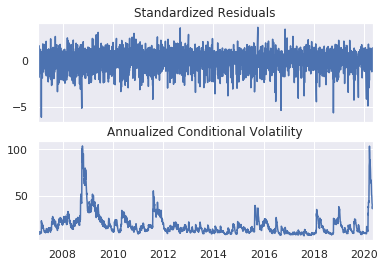

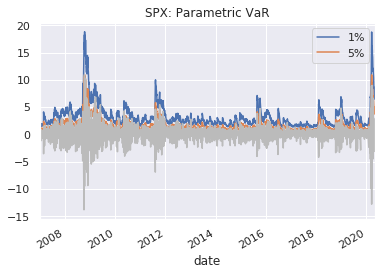

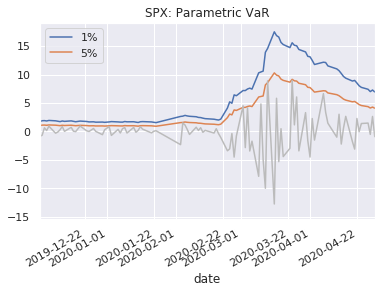

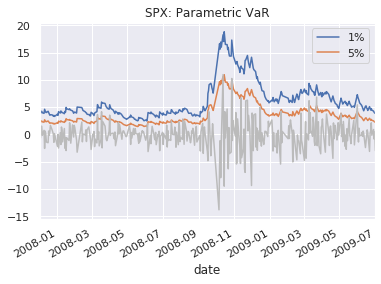

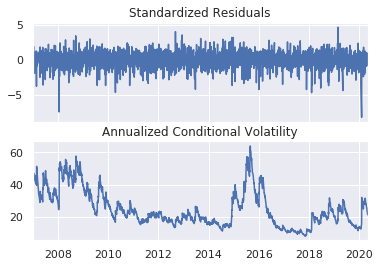

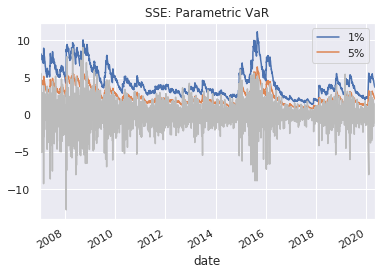

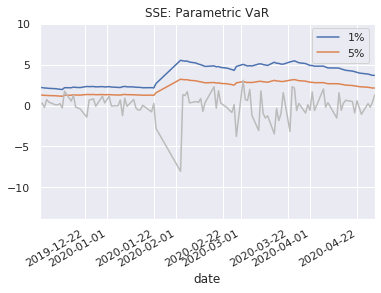

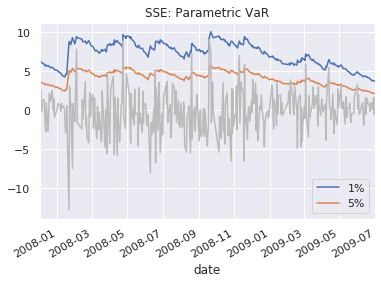

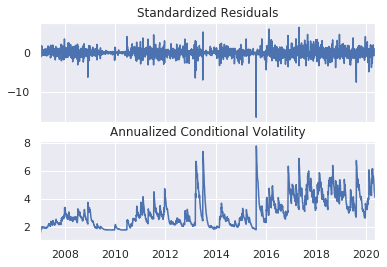

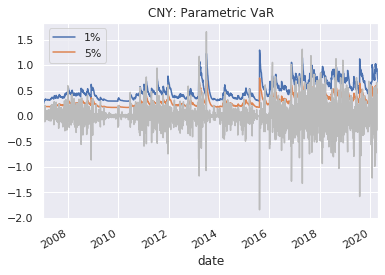

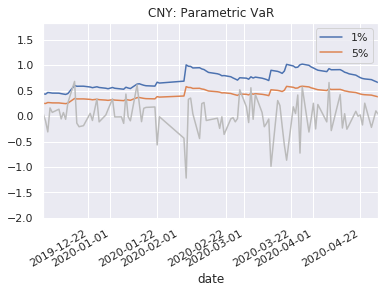

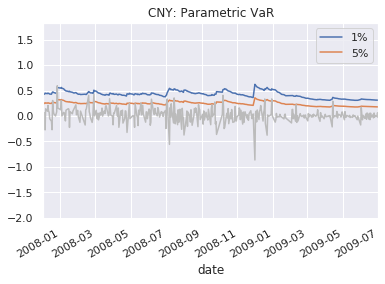

In [147]:
# Parametrically-fitted VaR Series for the three assets in the Full Timeframe
# Great Recession time-period slice of Full-range VaR Series
# COVID-19 time-period slice of VaR forecast data based on training data from 2007-2018
# Graphs showing how closely fitted the VaR series are with historical asset returns.

GR_VaR = {}
CR_forecast_VaR = {}

for col in COLS_EXCL_VIX:
    resultsdb["ALL"][3][col] = VaR_parametric(col, scope="ALL", verbose=True)
    CR_forecast_VaR[col] = VaR_parametric(col, scope="ALL", 
                                          train_end_date=TRAIN_END, 
                                          forecast_start_date=FORECAST_START, 
                                          start_date=COVID_START, end_date=COVID_END, 
                                          verbose=False)
    GR_VaR[col] = VaR_parametric(col, scope="ALL", 
                                 start_date=GR_START, end_date=GR_END, 
                                 verbose=False)

In [148]:
# Granger Causality Implementation: Testing for Risk Spillover
from statsmodels.tsa.stattools import grangercausalitytests as granger_

def granger_bilateral(cause_data, effect_data, cause_title, effect_title, 
                      title, dateindex, confs=["5%","1%"], lag=20):
    if len(confs) > 0:
        results = {}
        data = (pd.DataFrame({cause_title: cause_data[conf],
                              effect_title: effect_data[conf]},
                             index=dateindex)
               for conf in confs)
        for dataframe, conf in zip(data, confs):
            forward = (granger_(dataframe[[effect_title, cause_title]], lag, verbose=False), 
                       (cause_title, effect_title), title, lag)
            backward = (granger_(dataframe[[cause_title, effect_title]], lag, verbose=False), 
                        (effect_title, cause_title), title, lag)
            results[conf] = (forward, backward)
        return results
    
    else:
        dataframe = pd.DataFrame({cause_title: cause_data,
                                  effect_title: effect_data},
                                 index=dateindex)
        forward = (granger_(dataframe[[effect_title, cause_title]], lag, verbose=False), 
                   (cause_title, effect_title), title, lag)
        backward = (granger_(dataframe[[cause_title, effect_title]], lag, verbose=False), 
                    (effect_title, cause_title), title, lag)
        return (forward, backward)
        
# Weak GC if p-value < alpha in >50% of lag entry F-tests
# Strong GC if >90%
# No GC if <50%
# Delayed effect if more than 3 out of the first 5 lags are non-significant or lag=1 is.
def print_granger(result, order, title, lag, conf, verbose=True):
    first_term = True
    yes_count = 0
    short_term = 0
    short_term_reject = ""
    
    header = title + ": \n" + order[0] + " -> " + order[1]
    causal_order = order[0] + " -> " + order[1]
    if verbose:
        print(header)
        print("Lag, Confidence Level, F-statistic, p-value, Granger-Causality")
    # Data
    for k,v in result.items():
        ftest = v[0]["params_ftest"]
        if ftest[1] < int(conf[0])*0.01:
            causality = "Yes"
            yes_count += 1
        else:
            causality = "No"
            if k == 1:
                first_term = False
            if k in range(1,6):
                short_term += 1
        if verbose:
            print(", ".join((str(k), conf, str(ftest[0]), str(ftest[1]), causality)))
    # Conclusion
    if yes_count >= lag / 2:
        if not first_term or short_term > 3:
            short_term_reject = "delayed"
        if yes_count >= lag * 0.9:
            if verbose:
                print("Strong Granger-Causality exists from " + order[0] + " to " + order[1] + " at conf=" + conf + ".")
            else:
                print(", ".join((causal_order, conf, "Strong", short_term_reject)))
        else:
            if verbose:
                print("Weak Granger-Causality exists from " + order[0] + " to " + order[1] + ".")
            else:
                print(", ".join((causal_order, conf, "Weak", short_term_reject)))
        if verbose and short_term_reject != "":
            print("But it is rejected in the short term.")
    else:
        if verbose:
            print("No Granger-Causality from " + order[0] + " to " + order[1] + ".")
        else:
            print(", ".join((causal_order, conf, "None")))
    if verbose:
        print()

Implied vs. Realized Volatility: 
SPX Realized Volatility (Rolling Window) -> VIX Daily Quotes
Lag, Confidence Level, F-statistic, p-value, Granger-Causality
1, 5%, 24.36829587360606, 8.376780865595236e-07, Yes
2, 5%, 2.7009439694860715, 0.0673001076912734, No
3, 5%, 1.3059024624766187, 0.27069385233580995, No
4, 5%, 1.4699643861241463, 0.2085883668982806, No
5, 5%, 0.6448726593099628, 0.66545799440954, No
6, 5%, 2.5179736001600603, 0.019637802234624267, Yes
7, 5%, 2.2226058614141286, 0.029756588743226644, Yes
8, 5%, 5.089394153457854, 2.5983024904153613e-06, Yes
9, 5%, 4.993771489332804, 1.0619260294716553e-06, Yes
10, 5%, 4.456360331424659, 2.9057411247828648e-06, Yes
11, 5%, 3.8245538542074256, 1.722318629862273e-05, Yes
12, 5%, 4.8983050226310185, 4.5632554687837134e-08, Yes
13, 5%, 4.7187361852546, 3.705047132457073e-08, Yes
14, 5%, 4.572146437319556, 2.8589436947672914e-08, Yes
15, 5%, 4.327698263415143, 4.3997478222031966e-08, Yes
16, 5%, 4.096907365324939, 7.349314586404613e-08

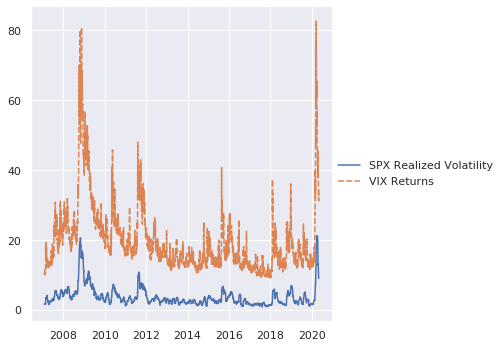

In [149]:
# Bidirectional Granger Causality in 
# Implied Volatility (VIX) vs. Realized Volatility from Historical Data.

def RealVolAnnualized(timeseries):
    real_var = timeseries.rolling(21).var() * (252 / 21)
    return np.sqrt(real_var.dropna())

spx_real_vol = RealVolAnnualized(df_lret["SPX"].copy())
sns.relplot(kind="line", data=pd.DataFrame({"SPX Realized Volatility": spx_real_vol, 
                                            "VIX Returns": df["VIX"].copy()},
                                            index=spx_real_vol.index).dropna())

realvol_forward, realvol_backward = granger_bilateral(spx_real_vol, df["VIX"].copy(), 
                                        "SPX Realized Volatility (Rolling Window)", 
                                        "VIX Daily Quotes", 
                                         title="Implied vs. Realized Volatility",
                                         dateindex=spx_real_vol.index, 
                                         confs=[], lag=40)

print_granger(*realvol_forward, conf="5%", verbose=True)
print_granger(*realvol_backward, conf="5%", verbose=True)

In [150]:
# Bidirectional Granger Causality of VaRs between SPX and SSE/CNY
# Full Timeframe, Great Recession, COVID-19 Recession compared.

VaRs = resultsdb["ALL"][0], resultsdb["ALL"][3], ["5%","1%"]
GR_VaRs = "Great Recession", GR_VaR, ["5%","1%"]
CR_VaRs = "COVID-19 Recession", CR_forecast_VaR, ["5%","1%"]

def print_grangers(VaR_datasets, verbose=False):
    for timeframe, VaR_df, confs in VaR_datasets:
        if not verbose:
            print("\n" + timeframe + ": \n")
        for CHN in ("SSE","CNY"):
            results = granger_bilateral(VaR_df["SPX"], VaR_df[CHN], 
                                       "SPX", CHN,
                                        title=timeframe, 
                                        dateindex=VaR_df["SPX"].index,
                                        lag=10,
                                        confs=confs)
            for k, v in results.items():
                print_granger(*v[0], conf=k, verbose=verbose)
                print_granger(*v[1], conf=k, verbose=verbose)
            
print_grangers((VaRs, GR_VaRs, CR_VaRs), verbose=False)
print()
print_grangers((VaRs, GR_VaRs, CR_VaRs), verbose=True)


Full Timeframe: 

SPX -> SSE, 5%, Strong, delayed
SSE -> SPX, 5%, Strong, 
SPX -> SSE, 1%, Strong, delayed
SSE -> SPX, 1%, Weak, 
SPX -> CNY, 5%, Strong, delayed
CNY -> SPX, 5%, None
SPX -> CNY, 1%, Strong, delayed
CNY -> SPX, 1%, None

Great Recession: 

SPX -> SSE, 5%, None
SSE -> SPX, 5%, None
SPX -> SSE, 1%, None
SSE -> SPX, 1%, None
SPX -> CNY, 5%, None
CNY -> SPX, 5%, None
SPX -> CNY, 1%, None
CNY -> SPX, 1%, None

COVID-19 Recession: 

SPX -> SSE, 5%, None
SSE -> SPX, 5%, None
SPX -> SSE, 1%, None
SSE -> SPX, 1%, None
SPX -> CNY, 5%, Strong, delayed
CNY -> SPX, 5%, None
SPX -> CNY, 1%, None
CNY -> SPX, 1%, None

Full Timeframe: 
SPX -> SSE
Lag, Confidence Level, F-statistic, p-value, Granger-Causality
1, 5%, 0.020540990733562286, 0.8860456927347979, No
2, 5%, 6.37135817154604, 0.001732166180033631, Yes
3, 5%, 7.702754916736141, 3.986847564304417e-05, Yes
4, 5%, 5.680061016640332, 0.00014907155929451304, Yes
5, 5%, 4.816079463366411, 0.00021718637386286964, Yes
6, 5%, 4.32685885

Great Recession: 
SPX -> CNY
Lag, Confidence Level, F-statistic, p-value, Granger-Causality
1, 5%, 0.06735404529728943, 0.7953741017932484, No
2, 5%, 0.15584983907237554, 0.8557445833899743, No
3, 5%, 0.18867245674849595, 0.9040894256169896, No
4, 5%, 0.370619304505021, 0.8295533564004811, No
5, 5%, 0.5717900331500594, 0.7216357151911237, No
6, 5%, 0.4883166883016896, 0.8170469564684453, No
7, 5%, 0.8525163959200913, 0.5444946874558552, No
8, 5%, 0.9450902085663048, 0.4792379199363729, No
9, 5%, 0.9188860086713676, 0.5086772764809278, No
10, 5%, 0.8136501981847651, 0.6156706236701033, No
No Granger-Causality from SPX to CNY.

Great Recession: 
CNY -> SPX
Lag, Confidence Level, F-statistic, p-value, Granger-Causality
1, 5%, 0.0364638931875246, 0.848665987384423, No
2, 5%, 0.7612649776145328, 0.46781533645245443, No
3, 5%, 0.6507875726553394, 0.5828906083496652, No
4, 5%, 0.8525951305201567, 0.4926684178228632, No
5, 5%, 1.438581079331992, 0.2096424586877312, No
6, 5%, 1.4170205715804343